Deep Learning Final Project
=============

# §1 Extraction, Exploration and Processing of the 32 x 32 Data
------------

[SVHN](http://ufldl.stanford.edu/housenumbers/) is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to [MNIST](http://yann.lecun.com/exdb/mnist/) (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labelled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images.

Overview

* 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10.
* 73257 in train_32x32, 26032 digits in test_32x32, and 531131 additional, somewhat less difficult samples in extra_32x32, to use as extra training data
* Comes in two formats:
 1. Original images with character level bounding boxes.
 2. 33 x 32 images centered around a single character (many of the images do contain some distractors at the sides).

In this notebook we work with the 32 x 32 image data. The original character bounding boxes are extended in the appropriate dimension to become square windows, so that resizing them to 32-by-32 pixels does not introduce aspect ratio distortions. This preprocessing introduces some distracting digits to the sides of the digit of interest.

Loading the .mat files creates 2 variables: X which is a 4-D matrix containing the images, and y which is a vector of class labels. To access the images, X(:,:,:,i) gives the i-th 32-by-32 RGB image, with class label y(i). 

In a previous iPython Notebook (0_SVHNDownloadExtract.ipynb), we downloaded the above data. Here we explore and process in preparation for training.

## 1.1 Import Modules

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import os
from IPython.display import display, Image
from scipy import ndimage
import scipy.io as sio
from six.moves import cPickle as pickle
import pandas as pd
import seaborn as sns

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1.2 Extract Data

In [2]:
# Notice the example index is on the final axis of X, we want it to be the first axis
# test function np.rollaxis
x = np.array([range(2*2*3*4)]).reshape(2,2,3,4)
print('x:', x.shape)
print('first row:')
print(x[:,:,:,0])
x = np.rollaxis(x,3)
print('x:', x.shape)
print('first column:')
print(x[0,:,:,:])

x: (2, 2, 3, 4)
first row:
[[[ 0  4  8]
  [12 16 20]]

 [[24 28 32]
  [36 40 44]]]
x: (4, 2, 2, 3)
first column:
[[[ 0  4  8]
  [12 16 20]]

 [[24 28 32]
  [36 40 44]]]


In [3]:
# We load the images and labels into numpy arrays
# We want the first index of the image to determine the particular example we are looking at (rather than the last)
# We also want the labels to be a 1D array rather than 2D

def get_data_and_labels(mat_filename):
    dataset = sio.loadmat(mat_filename)
    data, labels = dataset['X'], dataset['y']
    print('data shape: ', data.shape, 'labels shape: ', labels.shape)
    num_examples = labels.shape[0]
    data = np.rollaxis(data,3)
    labels = np.reshape(labels, (num_examples,))
    print('data shape: ', data.shape, 'labels shape: ', labels.shape, 'num examples: ', num_examples)
    return data, labels, num_examples

print('train data:')
train_data, train_labels, num_train_images = get_data_and_labels('data/32x32/train_32x32.mat')
print('test data:')
test_data,  test_labels,  num_test_images  = get_data_and_labels('data/32x32/test_32x32.mat')
print('extra:')
extra_data, extra_labels, num_extra_images = get_data_and_labels('data/32x32/extra_32x32.mat')

train data:
data shape:  (32, 32, 3, 73257) labels shape:  (73257, 1)
data shape:  (73257, 32, 32, 3) labels shape:  (73257,) num examples:  73257
test data:
data shape:  (32, 32, 3, 26032) labels shape:  (26032, 1)
data shape:  (26032, 32, 32, 3) labels shape:  (26032,) num examples:  26032
extra:
data shape:  (32, 32, 3, 531131) labels shape:  (531131, 1)
data shape:  (531131, 32, 32, 3) labels shape:  (531131,) num examples:  531131


## 1.3 Exploration

In [4]:
# Check function np.bincount

x = np.bincount(train_labels)
print(x, np.sum(x), num_train_images)

x = np.bincount(test_labels)
print(x, np.sum(x), num_test_images)

x = np.bincount(extra_labels)
print(x, np.sum(x), num_extra_images)

[    0 13861 10585  8497  7458  6882  5727  5595  5045  4659  4948] 73257 73257
[   0 5099 4149 2882 2523 2384 1977 2019 1660 1595 1744] 26032 26032
[    0 90560 74740 60765 50633 53490 41582 43997 35358 34456 45550] 531131 531131


train_32x32  test_32x32  extra_32x32
1      0.189211    0.195874     0.170504
2      0.144491    0.159381     0.140719
3      0.115989    0.110710     0.114407
4      0.101806    0.096919     0.095331
5      0.093943    0.091580     0.100710
6      0.078177    0.075945     0.078290
7      0.076375    0.077558     0.082836
8      0.068867    0.063768     0.066571
9      0.063598    0.061271     0.064873
10     0.067543    0.066994     0.085760

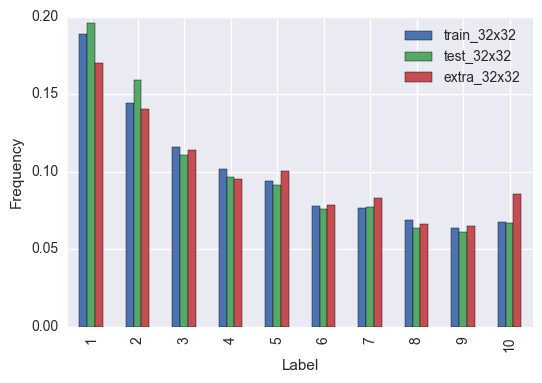

In [5]:
# Distribution of classes in the data

if not os.path.exists('Figures'):
    os.makedirs('Figures')

num_labels = 10
labels = range(1, num_labels+1) # labels are 1 through 10 (zeros are labelled 10)
class_dist = np.zeros((num_labels,3))

class_dist[:,0] = np.bincount(train_labels)[1:]
class_dist[:,1] = np.bincount(test_labels)[1:]
class_dist[:,2] = np.bincount(extra_labels)[1:]
    
class_dist = np.divide(class_dist,np.sum(class_dist, axis=0))

class_dist_df = pd.DataFrame(
    index = labels,
    columns = ['train_32x32', 'test_32x32', 'extra_32x32'],
    data = class_dist)
display(class_dist_df)

class_dist_df.plot(kind='bar').set(xlabel="Label", ylabel="Frequency")
savefig('Figures/digit_frequency.pdf')

We notice the classes are not balanced but the three datasets have a similar distribution of digits. The digit 1 appears in approximately 20% of the data while the digit 9 appears in only 6% of the images. The digit distribution seems plausible for a dataset of house humbers in a city.

Let's look at some of the data to make sure it looks sensible. Each exemplar should be a colour image of a digit rendered in a different font. We display a sample of the images that we just downloaded.

In [6]:
# test function np.where
print(train_labels[0],train_labels[1])
indices = np.where(train_labels==10)
print(indices)
print(indices[0])
print(train_labels[52])

1 9
(array([   52,    84,    93, ..., 73193, 73220, 73239]),)
[   52    84    93 ..., 73193 73220 73239]
10


training data examples


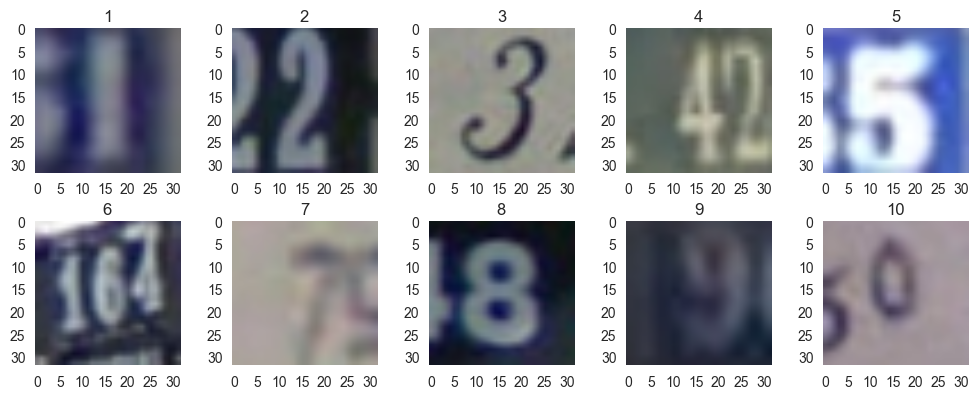

In [7]:
sns.set_style("dark")

sample_size = 10
train_indices = [0]*sample_size
test_indices = [0]*sample_size
extra_indices = [0]*sample_size

np.random.seed(133)

train_indices_by_class = []
for i in xrange(11):
    train_indices_by_class.append(np.where(train_labels==i)[0])

print('training data examples')
fig = plt.figure(figsize=(10,4))
for i in range(1,11):
    ax = fig.add_subplot(2,5,i)
    index = np.random.choice(train_indices_by_class[i])
    train_indices[i-1] = index
    plt.imshow(train_data[index])
    ax.set_title(train_labels[index])
plt.tight_layout()
fig = plt.gcf()
savefig('Figures/train_samples.pdf')

testing data examples


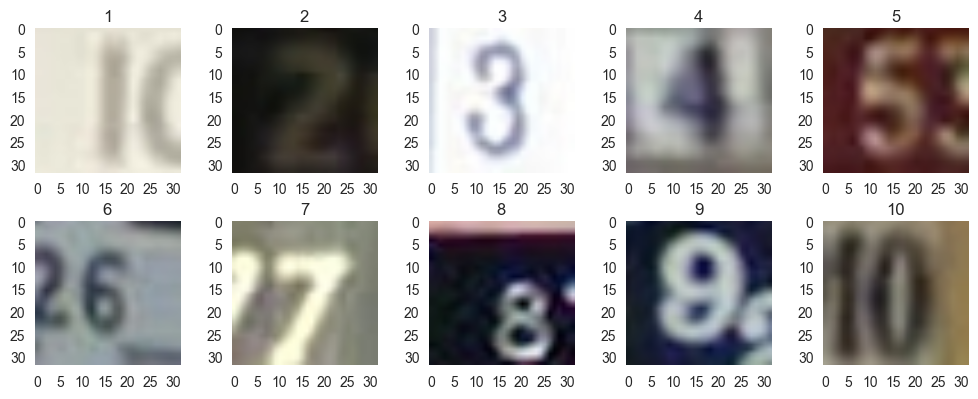

In [8]:
test_indices = [0]*sample_size

test_indices_by_class = []
for i in xrange(11):
    test_indices_by_class.append(np.where(test_labels==i)[0])

print('testing data examples')
fig = plt.figure(figsize=(10,4))
for i in range(1,11):
    ax = fig.add_subplot(2,5,i)
    index = np.random.choice(test_indices_by_class[i])
    test_indices[i-1] = index
    plt.imshow(test_data[index])
    ax.set_title(test_labels[index])
plt.tight_layout()
fig = plt.gcf()
savefig('Figures/test_samples.pdf')

extra data examples


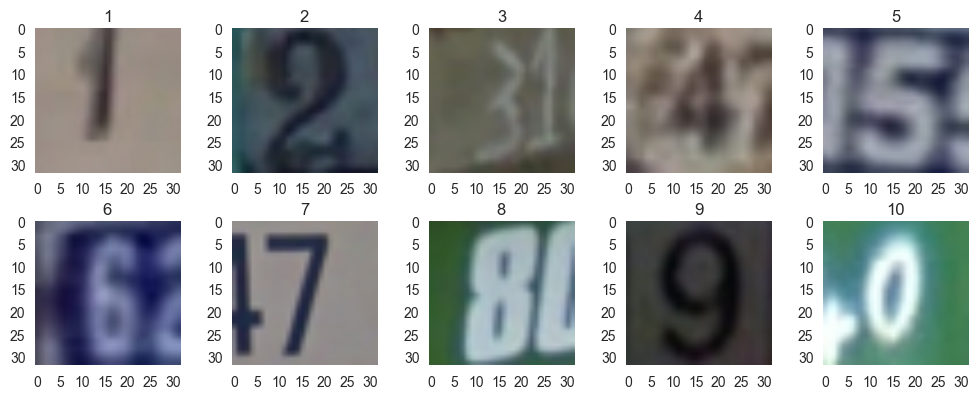

In [9]:
extra_indices = [0]*sample_size

extra_indices_by_class = []
for i in xrange(11):
    extra_indices_by_class.append(np.where(extra_labels==i)[0])

print('extra data examples')
fig = plt.figure(figsize=(10,4))
for i in range(1,11):
    ax = fig.add_subplot(2,5,i)
    index = np.random.choice(extra_indices_by_class[i])
    extra_indices[i-1] = index
    plt.imshow(extra_data[index])
    ax.set_title(extra_labels[index])
plt.tight_layout()
fig = plt.gcf()
savefig('Figures/extra_samples.pdf')

## 1.4 Process Data
### 1.4.1 Change the Labels of the Zero Digit Images from 10 to 0

In [10]:
x = np.array([[1,2,3],[4,5,6]])
print(x)
x[x==2]=10
print(x)

[[1 2 3]
 [4 5 6]]
[[ 1 10  3]
 [ 4  5  6]]


In [11]:
# Change class labels range 10 to class label 0
train_labels[train_labels == 10] = 0
test_labels[  test_labels == 10] = 0
extra_labels[extra_labels == 10] = 0

In [12]:
x = np.array([range(5*2*2*3)]).reshape((5,2,2,3))
print(x.shape)
y = np.mean(x, axis=3)
print(y.shape)

(5, 2, 2, 3)
(5, 2, 2)


### 1.4.2 Create Greyscale Versions of the Images

training data examples


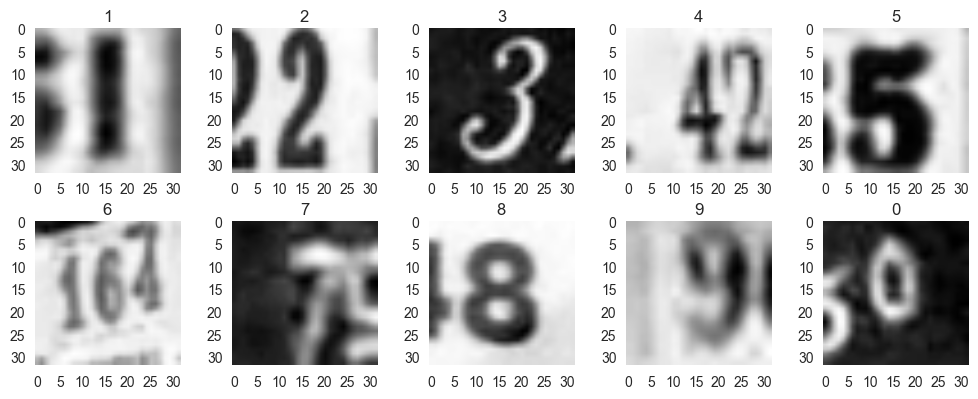

In [13]:
# Create a greyscale version of the photos to reduce the size of our training data by 
# We can check when training if the colour is important

gs_train_data  = np.mean(train_data, axis=3)
gs_test_data   = np.mean(test_data,  axis=3)
gs_extra_data  = np.mean(extra_data, axis=3)

# Now look at the same samples again in greyscale to see how they look
print('training data examples')
fig = plt.figure(figsize=(10,4))
for i in xrange(10):
    ax = fig.add_subplot(2,5,i+1)
    index = train_indices[i]
    plt.imshow(gs_train_data[index])
    ax.set_title(train_labels[index])
plt.tight_layout()
fig = plt.gcf()
savefig('Figures/train_samples_gs.pdf')

testing data examples


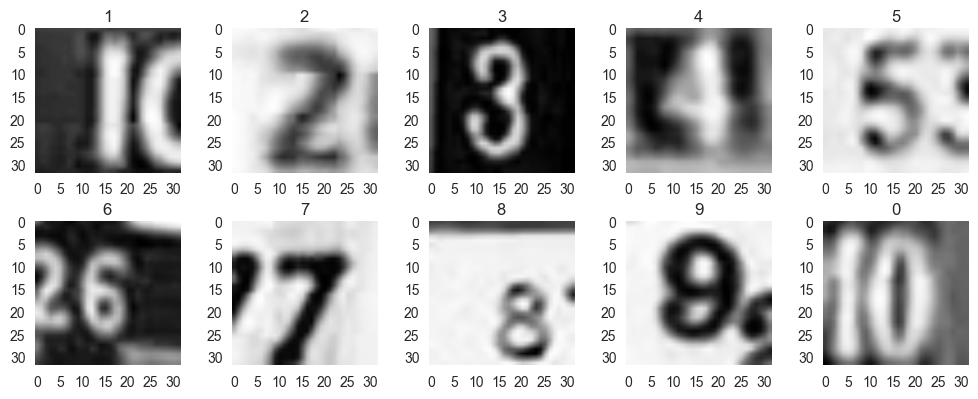

In [14]:
print('testing data examples')
fig = plt.figure(figsize=(10,4))
for i in xrange(10):
    ax = fig.add_subplot(2,5,i+1)
    index = test_indices[i]
    plt.imshow(gs_test_data[index])
    ax.set_title(test_labels[index])
plt.tight_layout()
fig = plt.gcf()
savefig('Figures/test_samples_gs.pdf')

extra data examples


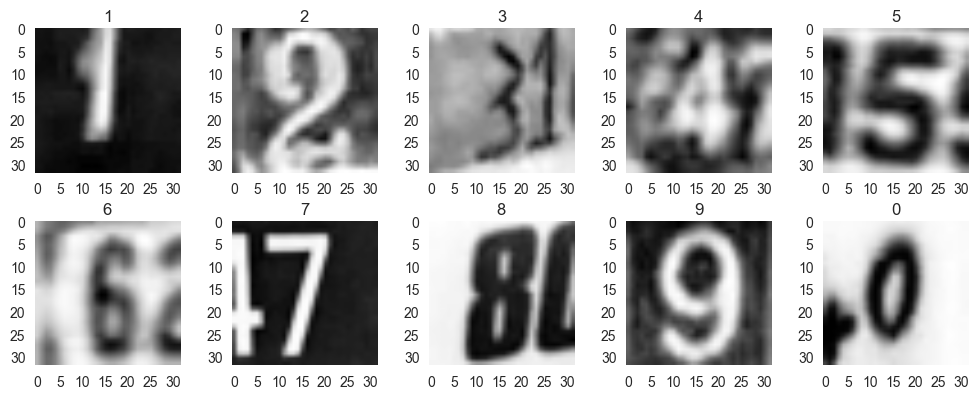

In [15]:
print('extra data examples')
fig = plt.figure(figsize=(10,4))
for i in xrange(10):
    ax = fig.add_subplot(2,5,i+1)
    index = extra_indices[i]
    plt.imshow(gs_extra_data[index])
    ax.set_title(extra_labels[index])
plt.tight_layout()
fig = plt.gcf()
savefig('Figures/extra_samples_gs.pdf')

### 1.4.3 Normalise the Image Data

In [16]:
# Check the stats of our datasets

num_images = np.array([num_train_images, num_test_images, num_extra_images], dtype=float)
image_stats = np.zeros((2,4))

print('Colour image stats:')

image_stats[0,0] = np.mean(train_data)
image_stats[0,1] = np.mean(test_data)
image_stats[0,2] = np.mean(extra_data)
total_mean = np.average(image_stats[0,:3], weights=num_images)
image_stats[0,3] = total_mean

image_stats[1,0] = np.std(train_data)
image_stats[1,1] = np.std(test_data)
image_stats[1,2] = np.std(extra_data)
total_std = np.sqrt(np.average(np.multiply(image_stats[1,:3], image_stats[1,:3]), weights=num_images))
image_stats[1,3] = total_std

image_stats_df = pd.DataFrame(
    index   = ['mean', 'std dev'],
    columns = ['train_32x32', 'test_32x32', 'extra_32x32', 'total'],
    data    = image_stats )
display(image_stats_df)

print('Greyscale image stats:')

image_stats[0,0] = np.mean(gs_train_data)
image_stats[0,1] = np.mean(gs_test_data)
image_stats[0,2] = np.mean(gs_extra_data)
total_mean_gs = np.average(image_stats[0,:3], weights=num_images)
image_stats[0,3] = total_mean_gs

image_stats[1,0] = np.std(gs_train_data)
image_stats[1,1] = np.std(gs_test_data)
image_stats[1,2] = np.std(gs_extra_data)
total_std_gs = np.sqrt(np.average(np.multiply(image_stats[1,:3], image_stats[1,:3]), weights=num_images))
image_stats[1,3] = total_std_gs

image_stats_df = pd.DataFrame(
    index   = ['mean', 'std dev'],
    columns = ['train_32x32', 'test_32x32', 'extra_32x32', 'total'],
    data    = image_stats )
display(image_stats_df)

Colour image stats:


train_32x32  test_32x32  extra_32x32       total
mean      115.111780  116.781171   110.588958  111.370222
std dev    50.819268   57.376367    50.487552   50.828938

Greyscale image stats:


train_32x32  test_32x32  extra_32x32       total
mean      115.111780  116.781171   110.588958  111.370222
std dev    49.476878   56.227676    48.748603   49.164613

In [17]:
# Normalise our image arrays so they have roughly zero mean and std dev one to make training easier later on

#image_size = 32      # Pixel width and height.
#pixel_depth = 255.0  # Number of levels per pixel.

def normalise (image_array, mean, stdev):
    return (image_array -  mean) / stdev

train_data = normalise(train_data, total_mean, total_std)
test_data  = normalise(test_data,  total_mean, total_std)
extra_data = normalise(extra_data, total_mean, total_std)

gs_train_data = normalise(gs_train_data, total_mean_gs, total_std_gs)
gs_test_data  = normalise(gs_test_data,  total_mean_gs, total_std_gs)
gs_extra_data = normalise(gs_extra_data, total_mean_gs, total_std_gs)

In [18]:
print('Colour image stats:')

image_stats[0,0] = np.mean(train_data)
image_stats[0,1] = np.mean(test_data)
image_stats[0,2] = np.mean(extra_data)
total_mean = np.average(image_stats[0,:3], weights=num_images)
image_stats[0,3] = total_mean

image_stats[1,0] = np.std(train_data)
image_stats[1,1] = np.std(test_data)
image_stats[1,2] = np.std(extra_data)
total_std = np.sqrt(np.average(np.multiply(image_stats[1,:3], image_stats[1,:3]), weights=num_images))
image_stats[1,3] = total_std

image_stats_df = pd.DataFrame(
    index   = ['mean', 'std dev'],
    columns = ['train_32x32', 'test_32x32', 'extra_32x32', 'total'],
    data    = image_stats )
display(image_stats_df)

print('Greyscale image stats:')

image_stats[0,0] = np.mean(gs_train_data)
image_stats[0,1] = np.mean(gs_test_data)
image_stats[0,2] = np.mean(gs_extra_data)
total_mean_gs = np.average(image_stats[0,:3], weights=num_images)
image_stats[0,3] = total_mean_gs

image_stats[1,0] = np.std(gs_train_data)
image_stats[1,1] = np.std(gs_test_data)
image_stats[1,2] = np.std(gs_extra_data)
total_std_gs = np.sqrt(np.average(np.multiply(image_stats[1,:3], image_stats[1,:3]), weights=num_images))
image_stats[1,3] = total_std_gs

image_stats_df = pd.DataFrame(
    index   = ['mean', 'std dev'],
    columns = ['train_32x32', 'test_32x32', 'extra_32x32', 'total'],
    data    = image_stats )
display(image_stats_df)

Colour image stats:


train_32x32  test_32x32  extra_32x32         total
mean        0.073611    0.106454    -0.015370  4.818553e-16
std dev     0.999810    1.128813     0.993284  1.000000e+00

Greyscale image stats:


train_32x32  test_32x32  extra_32x32         total
mean        0.076103    0.110058    -0.015891 -1.143180e-14
std dev     1.006351    1.143662     0.991538  1.000000e+00

training data examples


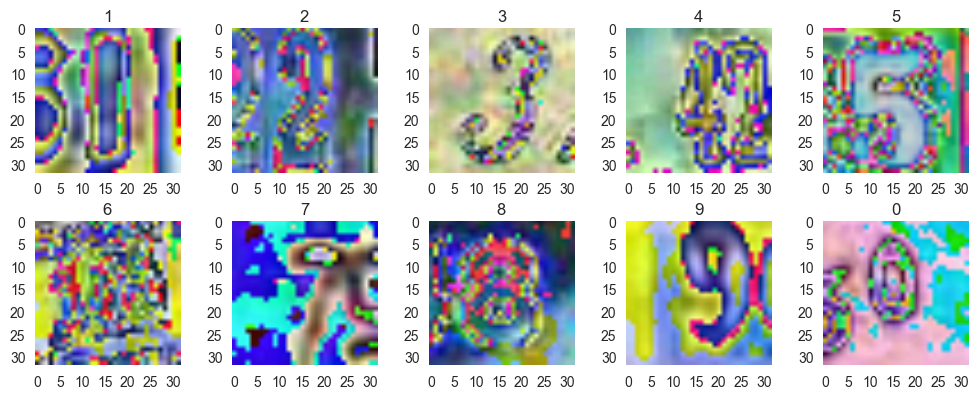

In [19]:
# Now look at the same colour samples again to see how they changed after normalising
print('training data examples')
fig = plt.figure(figsize=(10,4))
for i in xrange(10):
    ax = fig.add_subplot(2,5,i+1)
    index = train_indices[i]
    plt.imshow(train_data[index])
    ax.set_title(train_labels[index])
plt.tight_layout()
fig = plt.gcf()
savefig('Figures/train_samples_norm.pdf')

testing data examples


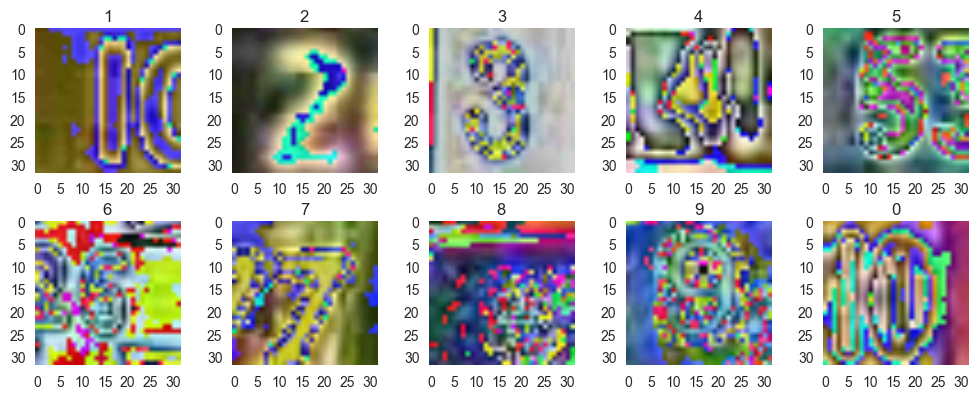

In [20]:
print('testing data examples')
fig = plt.figure(figsize=(10,4))
for i in xrange(10):
    ax = fig.add_subplot(2,5,i+1)
    index = test_indices[i]
    plt.imshow(test_data[index])
    ax.set_title(test_labels[index])
plt.tight_layout()
fig = plt.gcf()
savefig('Figures/test_samples_norm.pdf')

extra data examples


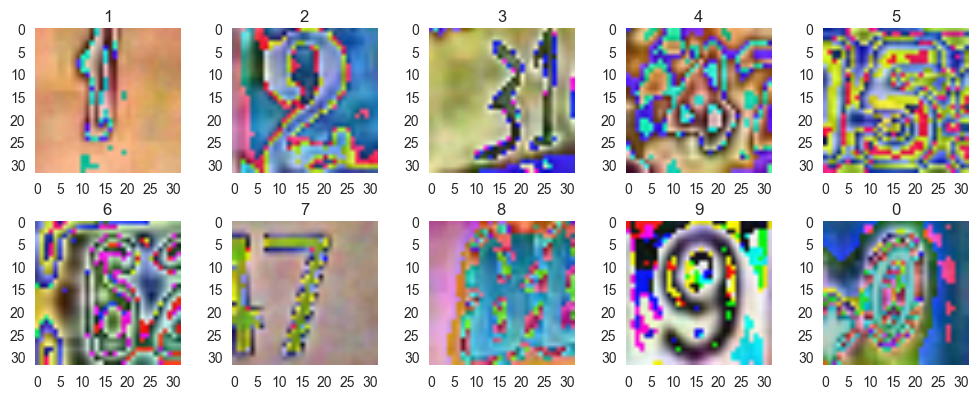

In [21]:
print('extra data examples')
fig = plt.figure(figsize=(10,4))
for i in xrange(10):
    ax = fig.add_subplot(2,5,i+1)
    index = extra_indices[i]
    plt.imshow(extra_data[index])
    ax.set_title(extra_labels[index])
plt.tight_layout()
fig = plt.gcf()
savefig('Figures/extra_samples_norm.pdf')

training data examples


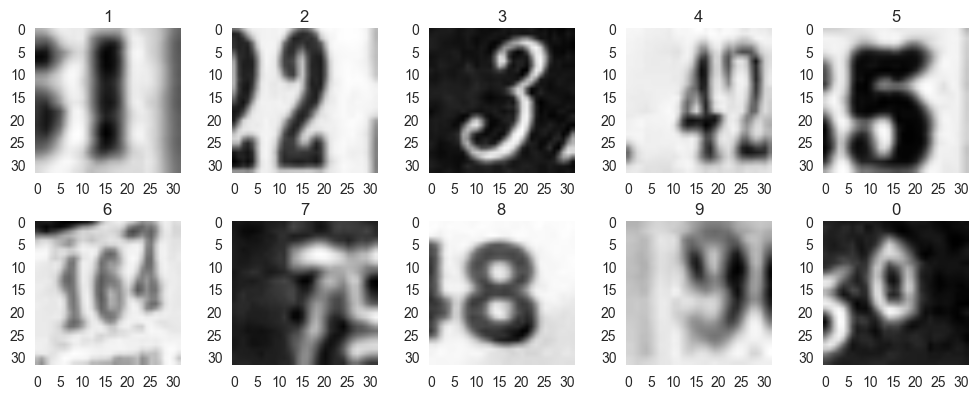

In [22]:
# Now look at the same greyscale samples again to see how they changed after normalising
print('training data examples')
fig = plt.figure(figsize=(10,4))
for i in xrange(10):
    ax = fig.add_subplot(2,5,i+1)
    index = train_indices[i]
    plt.imshow(gs_train_data[index])
    ax.set_title(train_labels[index])
plt.tight_layout()
fig = plt.gcf()
savefig('Figures/train_samples_gs_norm.pdf')

testing data examples


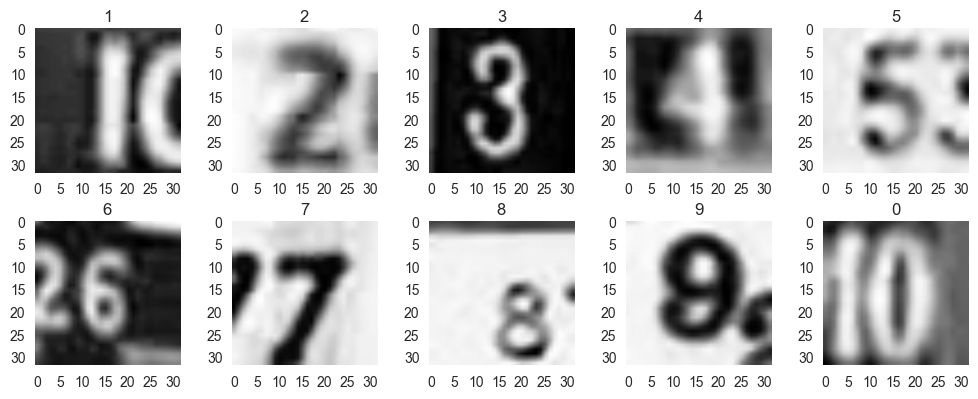

In [23]:
print('testing data examples')
fig = plt.figure(figsize=(10,4))
for i in xrange(10):
    ax = fig.add_subplot(2,5,i+1)
    index = test_indices[i]
    plt.imshow(gs_test_data[index])
    ax.set_title(test_labels[index])
plt.tight_layout()
fig = plt.gcf()
savefig('Figures/test_samples_gs_norm.pdf')

extra data examples


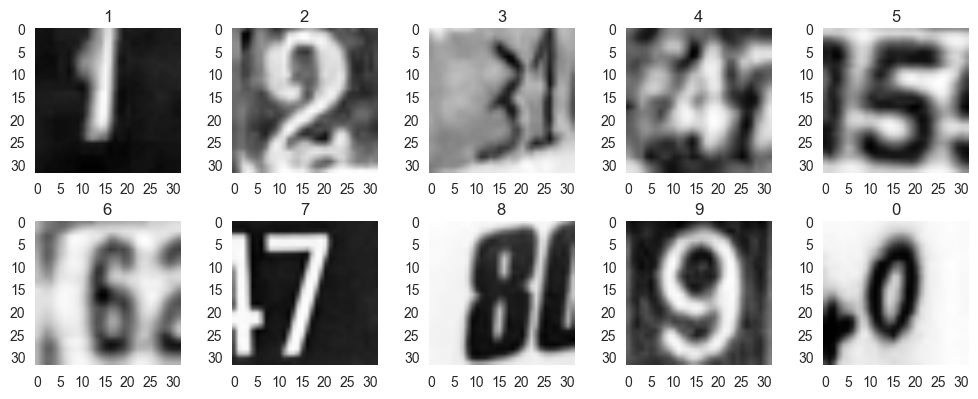

In [24]:
print('extra data examples')
fig = plt.figure(figsize=(10,4))
for i in xrange(10):
    ax = fig.add_subplot(2,5,i+1)
    index = extra_indices[i]
    plt.imshow(gs_extra_data[index])
    ax.set_title(extra_labels[index])
plt.tight_layout()
fig = plt.gcf()
savefig('Figures/extra_samples_gs_norm.pdf')

### 1.4.4 Shuffle the Samples

In [25]:
# The data seems shuffled but we'll shuffle it anyway just to be sure

def randomize(dataset, gs_dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:,:]
  shuffled_dataset_gs = gs_dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_dataset_gs, shuffled_labels

train_data, gs_train_data, train_labels = randomize(train_data, gs_train_data, train_labels)
test_data,  gs_test_data,  test_labels  = randomize(test_data,  gs_test_data,  test_labels)
extra_data, gs_extra_data, extra_labels = randomize(extra_data, gs_extra_data, extra_labels)

training data examples


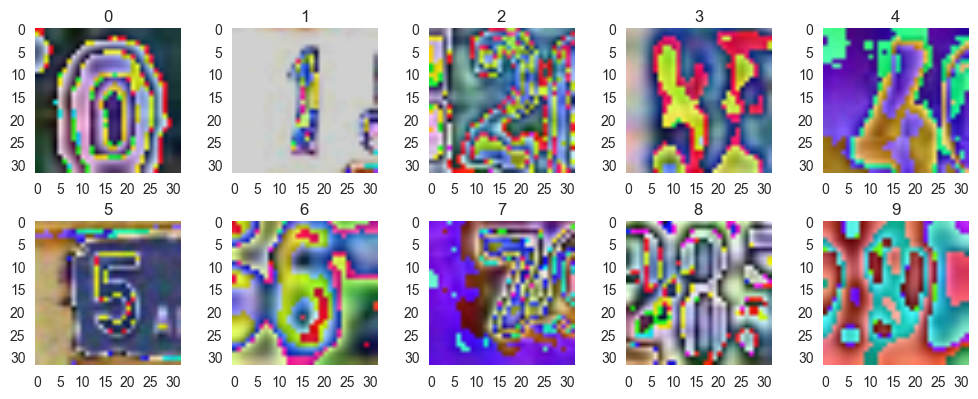

In [26]:
# Check our shuffle was ok and the data still looks good

np.random.seed(133) # if we've shuffled them, these samples should be different to the previous ones

train_indices_by_class = []
for i in xrange(10):
    train_indices_by_class.append(np.where(train_labels==i)[0])

print('training data examples')
fig = plt.figure(figsize=(10,4))
for i in xrange(10):
    ax = fig.add_subplot(2,5,i+1)
    index = np.random.choice(train_indices_by_class[i])
    train_indices[i] = index
    plt.imshow(train_data[index])
    ax.set_title(train_labels[index])
plt.tight_layout()
fig = plt.gcf()

testing data examples


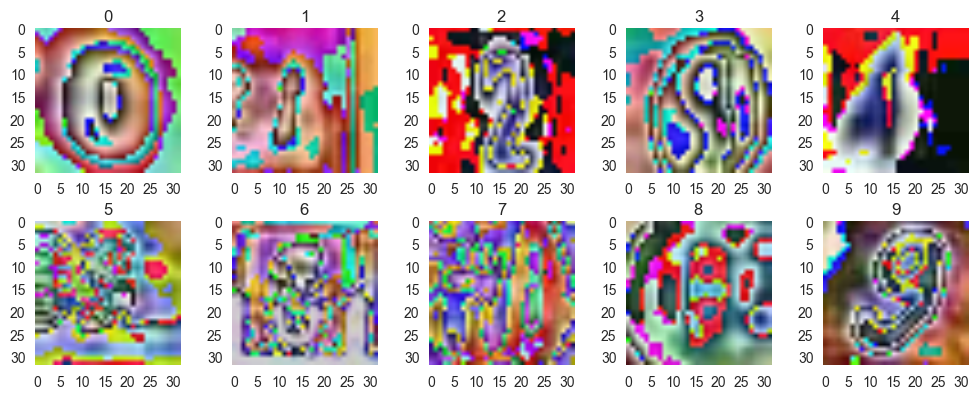

In [27]:
test_indices_by_class = []
for i in xrange(10):
    test_indices_by_class.append(np.where(test_labels==i)[0])

print('testing data examples')
fig = plt.figure(figsize=(10,4))
for i in xrange(10):
    ax = fig.add_subplot(2,5,i+1)
    index = np.random.choice(test_indices_by_class[i])
    test_indices[i] = index
    plt.imshow(test_data[index])
    ax.set_title(test_labels[index])
plt.tight_layout()
fig = plt.gcf()

extra data examples


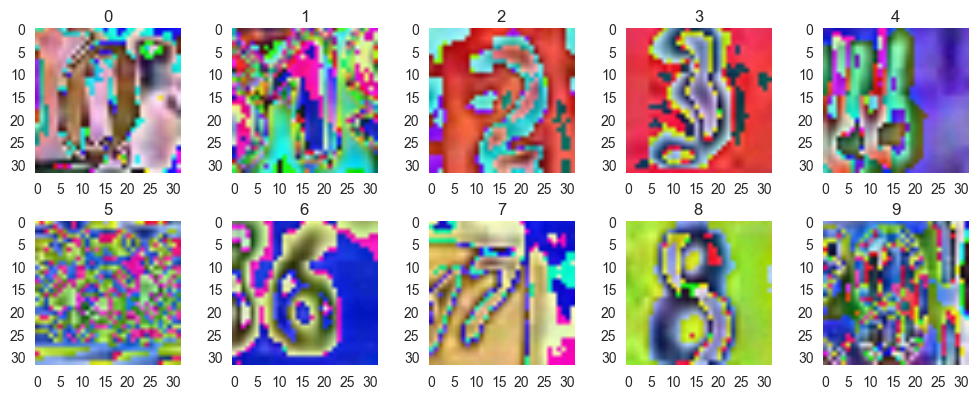

In [28]:
extra_indices_by_class = []
for i in xrange(10):
    extra_indices_by_class.append(np.where(extra_labels==i)[0])

print('extra data examples')
fig = plt.figure(figsize=(10,4))
for i in xrange(10):
    ax = fig.add_subplot(2,5,i+1)
    index = np.random.choice(extra_indices_by_class[i])
    extra_indices[i] = index
    plt.imshow(extra_data[index])
    ax.set_title(extra_labels[index])
plt.tight_layout()
fig = plt.gcf()

training data examples


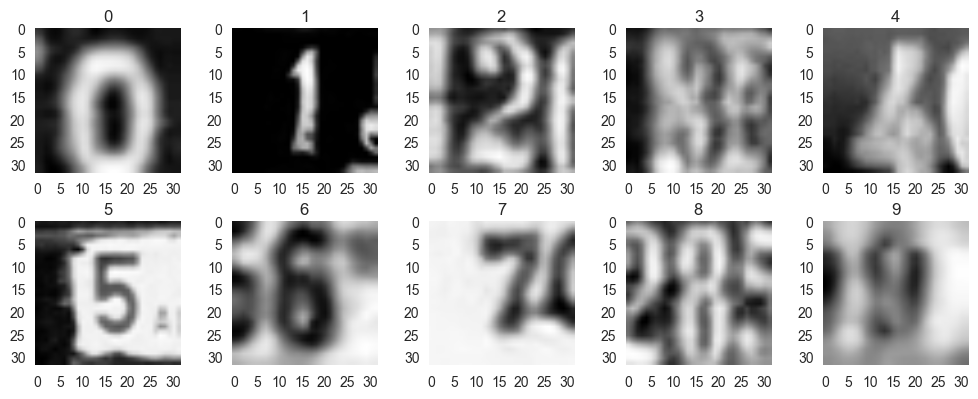

In [29]:
print('training data examples')
fig = plt.figure(figsize=(10,4))
for i in xrange(10):
    ax = fig.add_subplot(2,5,i+1)
    index = train_indices[i]
    plt.imshow(gs_train_data[index])
    ax.set_title(train_labels[index])
plt.tight_layout()
fig = plt.gcf()

testing data examples


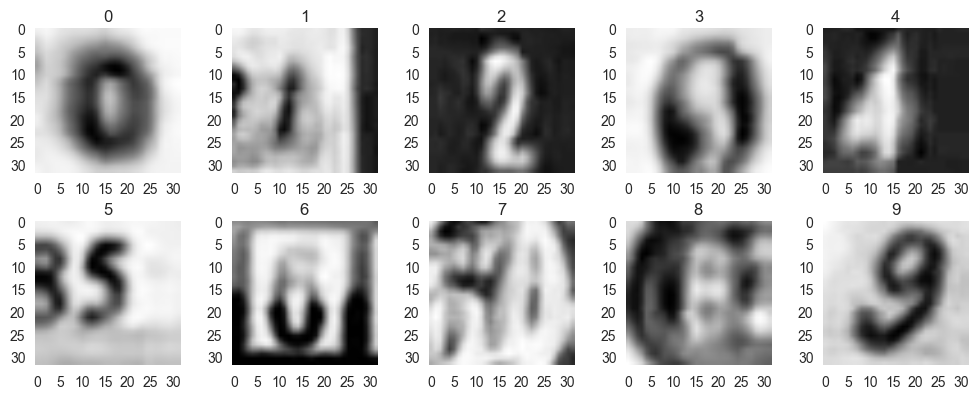

In [30]:
print('testing data examples')
fig = plt.figure(figsize=(10,4))
for i in xrange(10):
    ax = fig.add_subplot(2,5,i+1)
    index = test_indices[i]
    plt.imshow(gs_test_data[index])
    ax.set_title(test_labels[index])
plt.tight_layout()
fig = plt.gcf()

extra data examples


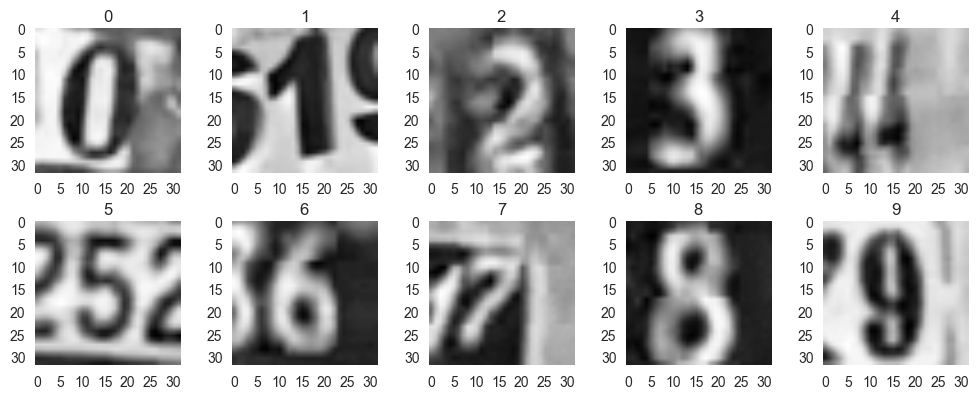

In [31]:
print('extra data examples')
fig = plt.figure(figsize=(10,4))
for i in xrange(10):
    ax = fig.add_subplot(2,5,i+1)
    index = extra_indices[i]
    plt.imshow(gs_extra_data[index])
    ax.set_title(extra_labels[index])
plt.tight_layout()
fig = plt.gcf()

## 1.5 Save the processed data for use later

In [33]:
# Pickle our processed data so we can access it easily in later iPython Notebooks

def maybe_pickle(data, labels, folder, pickle_file, force=False):
    '''Check if the directory exists, if not make it.'''
    if not os.path.exists(folder):
        os.makedirs(folder)
    if os.path.exists(folder+pickle_file) and not force:
        # You may override by setting force=True.
        statinfo = os.stat(folder+pickle_file)
        print(pickle_file, 'already present - skipping pickling. Pickle size:', statinfo.st_size)
    else:
        print('Pickling %s.' % pickle_file)
        try:
            f = open(folder+pickle_file, 'wb')
            save = {'data': data,
                    'labels': labels,}
            pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
            f.close()
        except Exception as e:
            print('Unable to save data to', pickle_file, ':', e)
            raise
        statinfo = os.stat(folder+pickle_file)
        print('Pickle file: ', pickle_file, 'Pickle size: ', statinfo.st_size)

maybe_pickle(train_data, train_labels, 'data/32x32/colour/', 'train.pickle')
maybe_pickle(test_data,  test_labels,  'data/32x32/colour/', 'test.pickle')

maybe_pickle(gs_train_data, train_labels, 'data/32x32/greyscale/', 'gs_train.pickle')
maybe_pickle(gs_test_data,  test_labels,  'data/32x32/greyscale/', 'gs_test.pickle')

Pickling train.pickle.
Pickle file:  train.pickle Pickle size:  1800437522
Pickling test.pickle.
Pickle file:  test.pickle Pickle size:  639788693
Pickling gs_train.pickle.
Pickle file:  gs_train.pickle Pickle size:  600194831
Pickling gs_test.pickle.
Pickle file:  gs_test.pickle Pickle size:  213280402


In [34]:
# extra_data is too big so we split it

num_splits = 3
temp = num_extra_images // num_splits
print(extra_labels[:temp].shape)

maybe_pickle(gs_extra_data[        :temp,:,:], extra_labels[        :temp], 'data/32x32/greyscale/', 'gs_extra1.pickle')
maybe_pickle(gs_extra_data[  temp:2*temp,:,:], extra_labels[  temp:2*temp], 'data/32x32/greyscale/', 'gs_extra2.pickle')
maybe_pickle(gs_extra_data[2*temp:3*temp,:,:], extra_labels[2*temp:3*temp], 'data/32x32/greyscale/', 'gs_extra3.pickle')

num_splits = 7
temp = num_extra_images // num_splits
print(extra_labels[:temp].shape)

maybe_pickle(extra_data[      :  temp,:,:,:], extra_labels[      :  temp], 'data/32x32/colour/', 'extra1.pickle')
maybe_pickle(extra_data[  temp:2*temp,:,:,:], extra_labels[  temp:2*temp], 'data/32x32/colour/', 'extra2.pickle')
maybe_pickle(extra_data[2*temp:3*temp,:,:,:], extra_labels[2*temp:3*temp], 'data/32x32/colour/', 'extra3.pickle')
maybe_pickle(extra_data[3*temp:4*temp,:,:,:], extra_labels[3*temp:4*temp], 'data/32x32/colour/', 'extra4.pickle')
maybe_pickle(extra_data[4*temp:5*temp,:,:,:], extra_labels[4*temp:5*temp], 'data/32x32/colour/', 'extra5.pickle')
maybe_pickle(extra_data[5*temp:6*temp,:,:,:], extra_labels[5*temp:6*temp], 'data/32x32/colour/', 'extra6.pickle')
maybe_pickle(extra_data[6*temp:      ,:,:,:], extra_labels[6*temp:      ], 'data/32x32/colour/', 'extra7.pickle')

(177043,)
Pickling gs_extra1.pickle.
Pickle file:  gs_extra1.pickle Pickle size:  1450513529
Pickling gs_extra2.pickle.
Pickle file:  gs_extra2.pickle Pickle size:  1450513529
Pickling gs_extra3.pickle.
Pickle file:  gs_extra3.pickle Pickle size:  1450513529
(75875,)
Pickling extra1.pickle.
Pickle file:  extra1.pickle Pickle size:  1864780108
Pickling extra2.pickle.
Pickle file:  extra2.pickle Pickle size:  1864780108
Pickling extra3.pickle.
Pickle file:  extra3.pickle Pickle size:  1864780108
Pickling extra4.pickle.
Pickle file:  extra4.pickle Pickle size:  1864780108
Pickling extra5.pickle.
Pickle file:  extra5.pickle Pickle size:  1864780108
Pickling extra6.pickle.
Pickle file:  extra6.pickle Pickle size:  1864780108
Pickling extra7.pickle.
Pickle file:  extra7.pickle Pickle size:  1864927570


In [35]:
# Now we've pickled everything we can delete stuff and free up memory
del train_data, test_data, extra_data
del train_labels, test_labels, extra_labels
del gs_train_data, gs_test_data, gs_extra_data